In [ ]:
!pip install -U gdown

In [ ]:
import gdown

file_id = "1DkZyM5--du7ToSeyZfPkxIezfAjg6iiw"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="cleaned_data.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1DkZyM5--du7ToSeyZfPkxIezfAjg6iiw
From (redirected): https://drive.google.com/uc?id=1DkZyM5--du7ToSeyZfPkxIezfAjg6iiw&confirm=t&uuid=d95b1277-f7c5-4cf1-ac76-e93c5ed2aaaf
To: /content/cleaned_data.zip
100%|██████████| 4.52G/4.52G [00:59<00:00, 75.8MB/s]


'cleaned_data.zip'

In [ ]:
import zipfile

with zipfile.ZipFile("cleaned_data.zip", 'r') as zip_ref:
    zip_ref.extractall("unzipped_data")

In [ ]:
import os

# List folders inside unzipped_data
for folder in os.listdir("unzipped_data"):
    print(folder)

cleaned_data


In [ ]:
import os
import random
import shutil
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# الإعدادات
dataset_path = "unzipped_data/cleaned_data"  # ✅ المسار الجديد في Colab
target_size = (224, 224)  # حجم الصورة المطلوب
min_resolution = (100, 100)  # أقل حجم مقبول للصورة
min_images = 100
max_images = 150
min_threshold = 10

# Augmentation pipeline
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(target_size[0], scale=(0.8, 1.0))
])

# دالة توليد صورة معدلة (Augmented)
def augment_image(image_path, save_path, index):
    image = Image.open(image_path).convert("RGB")
    augmented = augmentation(image)
    augmented = augmented.resize(target_size)
    augmented.save(f"{save_path}/aug_{index}.jpg")

# المعالجة الشاملة لكل كلاس
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # 1. تنظيف الصور من المقاسات الغريبة وتصغيرها
    valid_images = []
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            w, h = img.size
            if w < min_resolution[0] or h < min_resolution[1]:
                os.remove(img_path)
                continue
            img = img.resize(target_size)
            img.save(img_path)
            valid_images.append(img_name)
        except:
            if os.path.exists(img_path):
                os.remove(img_path)

    # تحديث عدد الصور بعد التنظيف
    image_count = len(valid_images)

    # 2. حذف الكلاسات الضعيفة جدًا
    if image_count < min_threshold:
        shutil.rmtree(class_path)
        print(f"🗑️ Removed class '{class_name}' (less than {min_threshold} images)")
        continue

    # 3. تقليل عدد الصور في الكلاسات الكبيرة
    elif image_count > max_images:
        images_to_remove = image_count - max_images
        images_to_delete = random.sample(valid_images, images_to_remove)
        for img in images_to_delete:
            os.remove(os.path.join(class_path, img))
        print(f"📉 Reduced '{class_name}' to {max_images} images")

    # 4. توليد صور إضافية للكلاسات الصغيرة
    elif image_count < min_images:
        images_needed = min_images - image_count
        valid_images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

        # ✅ التحقق إذا كان valid_images فارغ، نتجاهل التوليد بدل ما يحصل خطأ
        if not valid_images:
            print(f"⚠️ Skipping augmentation for '{class_name}' (no valid images found)")
            continue

        for i in range(images_needed):
            img_to_augment = random.choice(valid_images)
            augment_image(os.path.join(class_path, img_to_augment), class_path, i)
        print(f"🆙 Augmented '{class_name}' to {min_images} images")

print("\n✅ كل الكلاسات تم تنظيفها وتوحيد الصور وتوازن عدد الصور بينهم.")

# بعد انتهاء المعالجة نقوم بتجميع الداتا الجديدة في متغير new_data
new_data = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
        if image_files:  # التأكد من أن الكلاس يحتوي على صور
            new_data[class_name] = image_files

print("\n✅ تم حفظ الداتا الجديدة في المتغير new_data")


🗑️ Removed class 'Greco-Roman_Museum,_Alexandria' (less than 10 images)
🗑️ Removed class 'Sayeda_Aisha_Mosque' (less than 10 images)
🗑️ Removed class 'Qurnet_Murai' (less than 10 images)
🗑️ Removed class 'New_Kalabsha' (less than 10 images)
🗑️ Removed class 'Paromeos_Monastery' (less than 10 images)
📉 Reduced 'Hatshepsut Temple' to 150 images
🗑️ Removed class 'Hurghada_Grand_Aquarium' (less than 10 images)
🗑️ Removed class 'Relations_of_Egypt_and_Italy' (less than 10 images)
📉 Reduced 'Ramesseum' to 150 images
🗑️ Removed class 'Tomb_of_Kheruef' (less than 10 images)
🗑️ Removed class 'Abu_Qir_Bay' (less than 10 images)
🗑️ Removed class 'Pharaon_Island' (less than 10 images)
🗑️ Removed class 'Attarine_Mosque' (less than 10 images)
⚠️ Skipping augmentation for '24_Maat' (no valid images found)
🗑️ Removed class 'Pyramid_of_Seila' (less than 10 images)
🗑️ Removed class 'Qalawun_complex' (less than 10 images)
🗑️ Removed class 'Valley_of_the_Golden_Mummies' (less than 10 images)
🗑️ Removed cl

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 'new_data' is already defined as in your original notebook, containing image paths per class.
# Example structure of new_data (replace with your actual data loading):
# new_data = {
#     "Class1": ["path/to/image1_class1.jpg", "path/to/image2_class1.jpg", ...],
#     "Class2": ["path/to/image1_class2.jpg", "path/to/image2_class2.jpg", ...],
#     ...
# }
# Replace this with your actual data loading mechanism
# For demonstration, let's create a dummy new_data (replace with your actual data)
# Assuming new_data is already loaded as in your original notebook
# ----------------------------------------------------------------------
# 1. Data Preparation
# ----------------------------------------------------------------------

image_paths = []
labels = []

class_names = list(new_data.keys())
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

for class_name, paths in new_data.items():
    for path in paths:
        image_paths.append(path)
        labels.append(class_to_idx[class_name])

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# ----------------------------------------------------------------------
# 2. Custom Data Generator with Augmentation
# ----------------------------------------------------------------------

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224), num_classes=10, shuffle=True, augmentation=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
        self.augmentation = augmentation

        if self.augmentation:
            self.datagen = ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        X, y = self.__data_generation(batch_paths, batch_labels)
        return X, y

    def __data_generation(self, batch_paths, batch_labels):
        X = np.zeros((self.batch_size, *self.target_size, 3))
        y = np.zeros((self.batch_size, self.num_classes))

        for i, path in enumerate(batch_paths):
            img = load_img(path, target_size=self.target_size)
            img = img_to_array(img) / 255.0

            if self.augmentation:
                img = img.reshape((1,) + img.shape)
                # Correct way to get the next batch and extract the image
                it = self.datagen.flow(img, batch_size=1, seed=42) # Create an iterator
                augmented_images = it.__next__() # Use __next__() to get the next batch from iterator
                img = augmented_images[0] # Take the augmented image from the batch

            X[i] = img
            y[i] = to_categorical(batch_labels[i], num_classes=self.num_classes)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Initialize Data Generators
train_gen = CustomDataGenerator(train_paths, train_labels, batch_size=32, num_classes=len(class_names), augmentation=True)
test_gen = CustomDataGenerator(test_paths, test_labels, batch_size=32, num_classes=len(class_names), shuffle=False, augmentation=False)

# ----------------------------------------------------------------------
# 3. ResNet50 Transfer Learning Model with Batch Normalization and Dropout
# ----------------------------------------------------------------------

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ----------------------------------------------------------------------
# 4. Compile Model with Learning Rate Scheduling
# ----------------------------------------------------------------------

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
optimizer = Adam() # You can specify learning rate here if needed, e.g., Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# ----------------------------------------------------------------------
# 5. Train the Model
# ----------------------------------------------------------------------

epochs = 10 # You can increase this number for better performance, e.g., 20, 30, or more
history = model.fit(train_gen, epochs=epochs, validation_data=test_gen, callbacks=[reduce_lr])

# ----------------------------------------------------------------------
# 6. Evaluate the Model
# ----------------------------------------------------------------------

loss, acc = model.evaluate(test_gen)
print(f"\n✅ دقة النموذج على بيانات الاختبار: {acc * 100:.2f}%")

# ----------------------------------------------------------------------
# 7. Error Analysis (Classification Report and Misclassified Examples)
# ----------------------------------------------------------------------

y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels[:len(y_pred)]

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0)) # Added zero_division=0 to handle potential zero division in metrics

misclassified_data = []
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:
        misclassified_data.append({
            "Image Path": test_paths[i],
            "True Label": class_names[y_true[i]],
            "Predicted Label": class_names[y_pred[i]]
        })

misclassified_df = pd.DataFrame(misclassified_data)
print("\nFirst 10 Misclassified Examples:")
print(misclassified_df.head(10))

# ----------------------------------------------------------------------
# 8. (Optional) Plot Training History (Accuracy and Loss)
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 9. (Optional) Confusion Matrix
# ----------------------------------------------------------------------
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 16))
sns.heatmap(conf_mat, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,744,526 (94.39 MB)

 Trainable params: 1,155,790 (4.41 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_359']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


 21/531 ━━━━━━━━━━━━━━━━━━━━ 52:40 6s/step - accuracy: 0.0133 - loss: 5.6560

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the trained model (assuming you have already run the training part and 'model' is available)
# model = ...  # Your trained model from the previous steps is already in memory

# 2. Define the path to your test image
test_image_path = 'path/to/your/test_image.jpg'  # **Replace with the actual path to your image**

# 3. Load and preprocess the test image
img = load_img(test_image_path, target_size=(224, 224)) # Ensure target_size matches your training
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (model expects batches)


# 4. Make a prediction
prediction_probabilities = model.predict(img_array)

# 5. Get the predicted class index
predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0] # Get index of highest probability

# 6. Get the predicted class name
predicted_class_name = class_names[predicted_class_index] # Assuming 'class_names' list is still defined

# 7. Get the confidence score (probability) for the predicted class
confidence_score = prediction_probabilities[0][predicted_class_index]

# 8. Display the test image and the prediction
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class_name} (Confidence: {confidence_score*100:.2f}%)")
plt.axis('off') # Turn off axis numbers and ticks
plt.show()

print(f"✅ Predicted class index: {predicted_class_index}")
print(f"✅ Predicted class name: {predicted_class_name}")
print(f"✅ Confidence score: {confidence_score*100:.2f}%")

In [ ]:
# بعد انتهاء المعالجة نقوم بتجميع الداتا الجديدة في متغير new_data
new_data = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
        if image_files:  # التأكد من أن الكلاس يحتوي على صور
            new_data[class_name] = image_files

print("\n✅ تم حفظ الداتا الجديدة في المتغير new_data")



✅ تم حفظ الداتا الجديدة في المتغير new_data


Found 206 classes: ['10_The_HolyQuran', '11_King_Thutmose_III', '16_Nazlet_Khater_Skeleton', '21_A_silo', '25_Mahalawi_water_ewers', '26_Mamluk_Lamps', '27_Khedive_Ismail', '28_Mohamed_Talaat_Pasha_Harb', '29_Model_of_building', '30_Muhammad_Ali_Pasha', '31_Puplit _of_the_Mosque_of_Abu_Bakr_bin_Mazhar', '33_The_Madrasaa_and_Mosque_of_Sultan_Hassan', '34_Wekalet_al-Ghouri', '3_Hassan_Fathi', '40_Mashrabiya', '41_Astrolabe', '42_Baker', '43_The_Protective_Goddesses', '44_Miller', '45_Hapi_The_Scribe', '46_Thoth', '47_Ottoman_Period_Carpet', '48_Stela_of_King_Qaa', '49_Zainab_Khatun_house', '4_Royal_Statues', '50_God_Nilus', '5_Greek_Statues', '6_October_Bridge', '9_Box_ofthe_Holy Quran', 'Abdeen_Palace', 'Abu_Haggag_Mosque', 'Abu_el-Abbas_el-Mursi_Mosque', 'Agiba_beach', 'Akhenaten', 'Al-Aqmar_Mosque', 'Al-Ashraf_Mosque', 'Al-Azhar_Park_(Cairo)', 'Al-Ghuri_Complex', 'Al-Manyal_Palace_Museum', 'Al-Qurn', "Al-Salih_Tala'i_Mosque", "Al-Shate'e_Mosque", 'Alexandria_Opera_House', 'Alexandria_

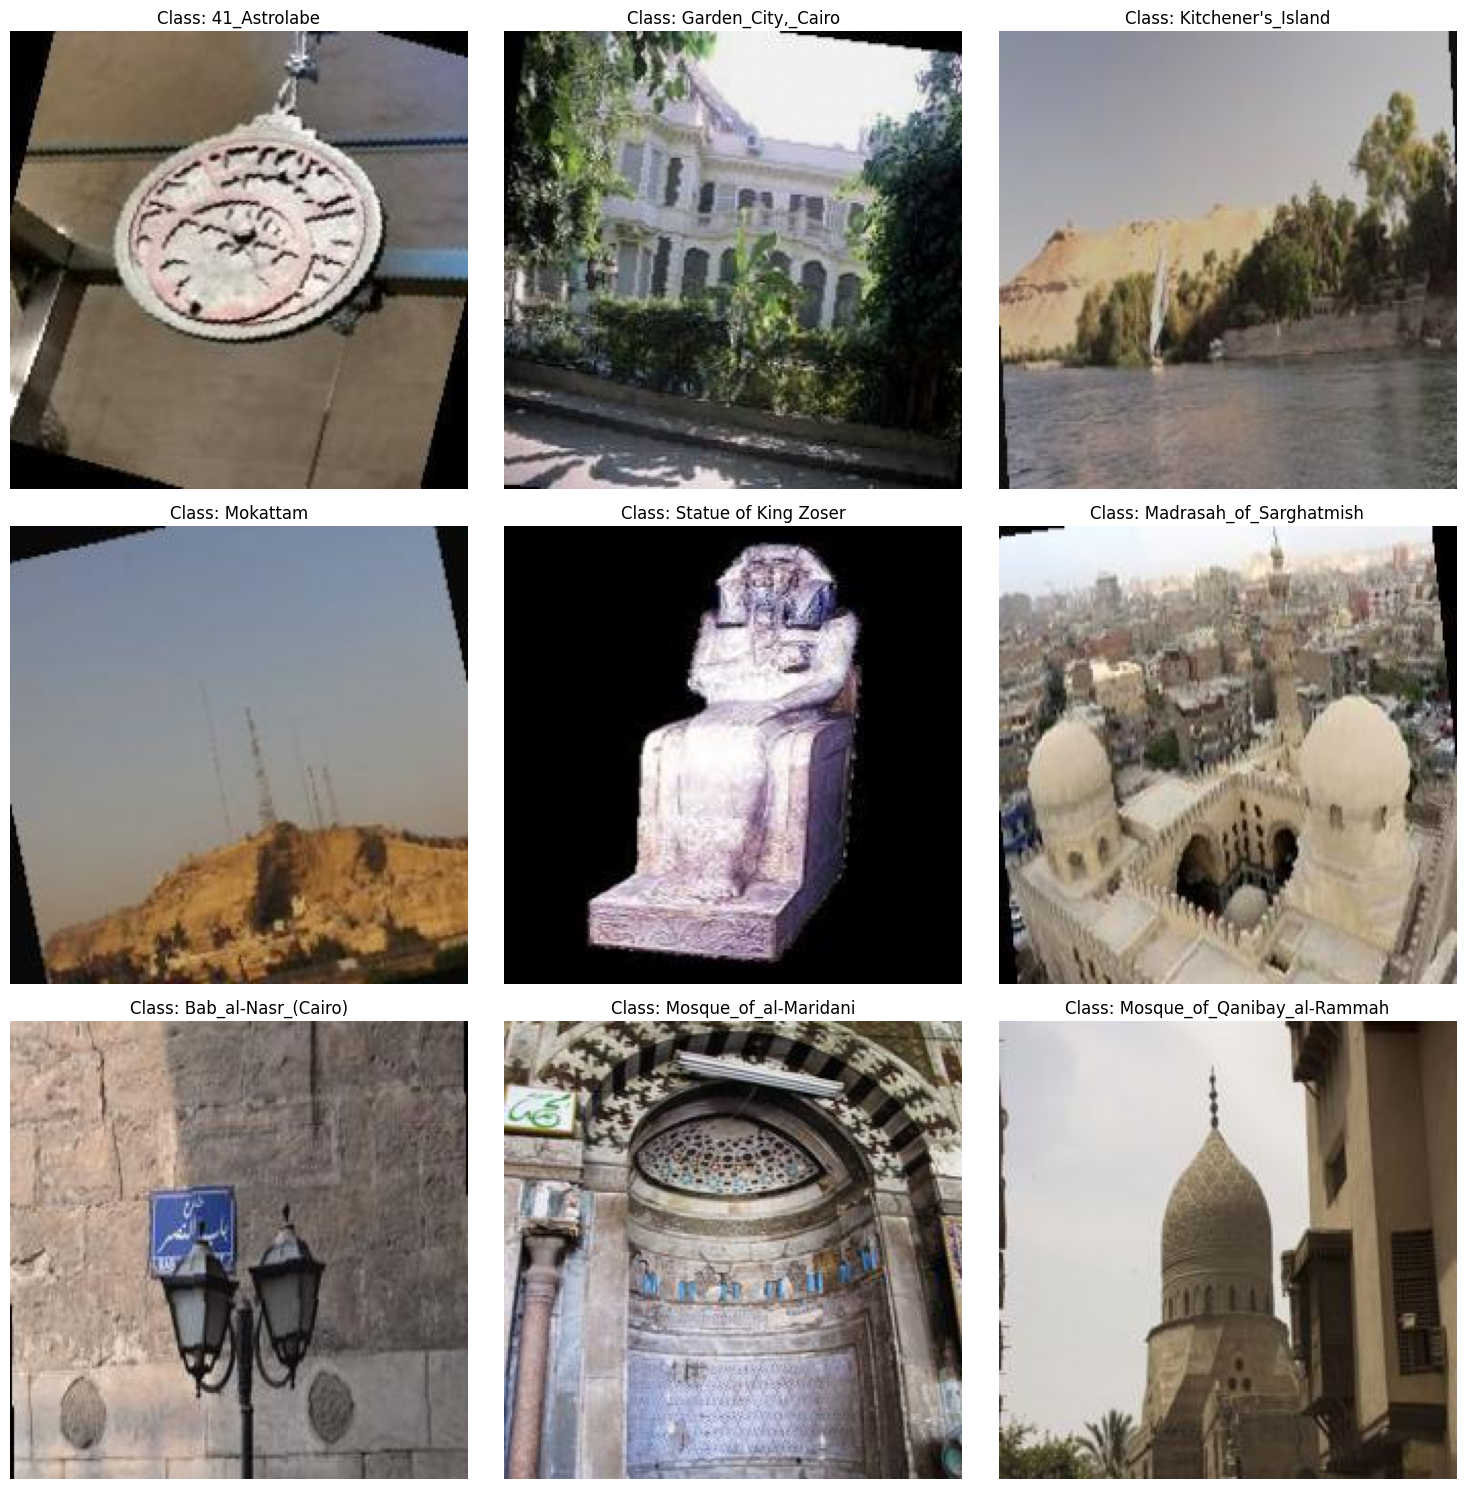

Visualization complete. Inspect images for correctness.
▶️ Building basic transfer‐learning model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,896,881 (18.68 MB)

 Trainable params: 843,726 (3.22 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

🚀 Training model...
Starting feature extraction phase...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.0047 - loss: 6.3192
Epoch 1: val_accuracy improved from -inf to 0.01151, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 99s 137ms/step - accuracy: 0.0047 - loss: 6.3189 - val_accuracy: 0.0115 - val_loss: 5.3869 - learning_rate: 1.0000e-04
Epoch 2/10
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0055 - loss: 5.8857
Epoch 2: val_accuracy improved from 0.01151 to 0.01175, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 103s 90ms/step - accuracy: 0.0055 - loss: 5.8856 - val_accuracy: 0.0117 - val_loss: 5.3036 - learning_rate: 1.0000e-04
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.0063 - loss: 5.7556
Epoch 3: val_accuracy improved from 0.01175 to 0.01339, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.0063 - loss: 5.7555 - val_accuracy: 0.0134 - val_loss: 5.2711 - learning_rate: 1.0000e-04
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0080 - loss: 5.6413
Epoch 4: val_accuracy improved from 0.01339 to 0.01574, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 53s 100ms/step - accuracy: 0.0080 - loss: 5.6412 - val_accuracy: 0.0157 - val_loss: 5.2343 - learning_rate: 1.0000e-04
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0087 - loss: 5.5591
Epoch 5: val_accuracy improved from 0.01574 to 0.01598, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.0087 - loss: 5.5590 - val_accuracy: 0.0160 - val_loss: 5.2085 - learning_rate: 1.0000e-04
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0109 - loss: 5.4722
Epoch 6: val_accuracy improved from 0.01598 to 0.01880, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.0109 - loss: 5.4722 - val_accuracy: 0.0188 - val_loss: 5.1832 - learning_rate: 1.0000e-04
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.0110 - loss: 5.4384
Epoch 7: val_accuracy improved from 0.01880 to 0.01997, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 86s 91ms/step - accuracy: 0.0110 - loss: 5.4384 - val_accuracy: 0.0200 - val_loss: 5.1567 - learning_rate: 1.0000e-04
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0122 - loss: 5.3850
Epoch 8: val_accuracy improved from 0.01997 to 0.02044, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.0122 - loss: 5.3850 - val_accuracy: 0.0204 - val_loss: 5.1335 - learning_rate: 1.0000e-04
Epoch 9/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0132 - loss: 5.3373
Epoch 9: val_accuracy improved from 0.02044 to 0.02185, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 81s 87ms/step - accuracy: 0.0132 - loss: 5.3373 - val_accuracy: 0.0219 - val_loss: 5.1239 - learning_rate: 1.0000e-04
Epoch 10/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0146 - loss: 5.2773
Epoch 10: val_accuracy improved from 0.02185 to 0.02773, saving model to best_egyptian_landmark_model.h5


532/532 ━━━━━━━━━━━━━━━━━━━━ 78s 79ms/step - accuracy: 0.0146 - loss: 5.2773 - val_accuracy: 0.0277 - val_loss: 5.1135 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.
Starting fine-tuning phase...
Epoch 11/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0059 - loss: 5.5833
Epoch 11: val_accuracy did not improve from 0.02773
532/532 ━━━━━━━━━━━━━━━━━━━━ 113s 140ms/step - accuracy: 0.0059 - loss: 5.5832 - val_accuracy: 0.0089 - val_loss: 5.3409 - learning_rate: 1.0000e-05
Epoch 12/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.0094 - loss: 5.4389
Epoch 12: val_accuracy did not improve from 0.02773
532/532 ━━━━━━━━━━━━━━━━━━━━ 95s 87ms/step - accuracy: 0.0094 - loss: 5.4389 - val_accuracy: 0.0115 - val_loss: 5.2687 - learning_rate: 1.0000e-05
Epoch 13/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.0090 - loss: 5.3922
Epoch 13: val_accuracy did not improve from 0.02773
532/532 ━━━━━━━━━━━━━━━━━━━━ 86s 94ms/step - a

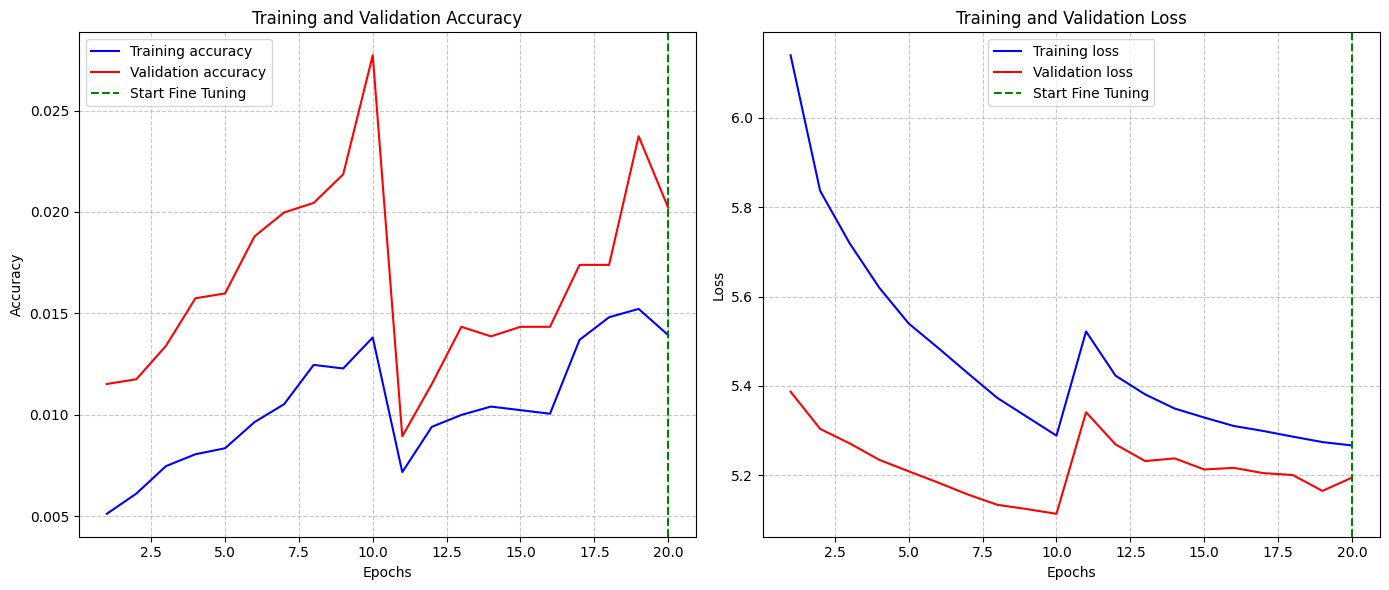

📊 Evaluating model...
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.0240 - loss: 5.1558

✅ Validation accuracy: 2.37%
🔍 Analyzing errors...
Generating predictions for 4256 test images...


ValueError: When passing a Python generator to a Keras model, the generator must return a tuple, either (input,) or (inputs, targets) or (inputs, targets, sample_weights). Received: [[[[-0.09019607 -0.35686272 -0.64705884]
   [-0.0745098  -0.34117645 -0.6313726 ]
   [-0.18431371 -0.45098037 -0.7254902 ]
   ...
   [ 0.09019613 -0.19999999 -0.41176468]
   [ 0.082353   -0.19999999 -0.40392154]
   [ 0.07450986 -0.20784312 -0.41176468]]

  [[-0.15294117 -0.41960782 -0.70980394]
   [-0.05882353 -0.32549018 -0.6156863 ]
   [-0.10588235 -0.372549   -0.64705884]
   ...
   [ 0.02745104 -0.26274508 -0.49019605]
   [ 0.03529418 -0.25490195 -0.46666664]
   [ 0.02745104 -0.24705881 -0.46666664]]

  [[-0.34117645 -0.60784316 -0.8980392 ]
   [-0.29411763 -0.56078434 -0.8509804 ]
   [-0.29411763 -0.5764706  -0.85882354]
   ...
   [-0.08235294 -0.38823527 -0.6313726 ]
   [-0.06666666 -0.372549   -0.6156863 ]
   [-0.0745098  -0.35686272 -0.60784316]]

  ...

  [[-0.29411763 -0.5058824  -0.73333335]
   [-0.32549018 -0.5372549  -0.7647059 ]
   [-0.3333333  -0.54509807 -0.77254903]
   ...
   [-0.3490196  -0.58431375 -0.7882353 ]
   [-0.36470586 -0.6        -0.8039216 ]
   [-0.372549   -0.60784316 -0.8117647 ]]

  [[-0.2862745  -0.4823529  -0.7254902 ]
   [-0.32549018 -0.52156866 -0.7647059 ]
   [-0.3490196  -0.54509807 -0.7882353 ]
   ...
   [-0.372549   -0.58431375 -0.79607844]
   [-0.38039213 -0.5921569  -0.8039216 ]
   [-0.38823527 -0.6        -0.8117647 ]]

  [[-0.27058822 -0.46666664 -0.70980394]
   [-0.31764704 -0.5137255  -0.75686276]
   [-0.3490196  -0.54509807 -0.7882353 ]
   ...
   [-0.36470586 -0.5764706  -0.7882353 ]
   [-0.36470586 -0.5764706  -0.7882353 ]
   [-0.36470586 -0.5764706  -0.7882353 ]]]


 [[[-0.9607843  -0.9607843  -0.94509804]
   [-0.9764706  -0.9764706  -0.9607843 ]
   [-0.9764706  -0.9764706  -0.9607843 ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -0.99215686 -1.        ]
   [-1.         -0.99215686 -1.        ]]

  [[-1.         -1.         -0.9843137 ]
   [-1.         -1.         -0.9843137 ]
   [-1.         -1.         -0.9843137 ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -0.99215686 -1.        ]
   [-1.         -0.99215686 -1.        ]]

  [[-0.9529412  -0.9529412  -0.9529412 ]
   [-0.9529412  -0.9529412  -0.9529412 ]
   [-0.9607843  -0.9607843  -0.9607843 ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -0.99215686 -1.        ]
   [-1.         -0.99215686 -1.        ]]

  ...

  [[ 0.6627451   0.62352943  0.5764706 ]
   [ 0.6627451   0.62352943  0.5764706 ]
   [ 0.6627451   0.62352943  0.5764706 ]
   ...
   [ 0.6313726   0.5921569   0.54509807]
   [ 0.5764706   0.5372549   0.4901961 ]
   [ 0.7647059   0.7254902   0.6784314 ]]

  [[ 0.6627451   0.62352943  0.5764706 ]
   [ 0.6627451   0.62352943  0.5764706 ]
   [ 0.6627451   0.62352943  0.5764706 ]
   ...
   [ 0.69411767  0.654902    0.60784316]
   [ 0.2313726   0.19215691  0.14509809]
   [ 0.43529415  0.39607847  0.34901965]]

  [[ 0.6627451   0.62352943  0.5764706 ]
   [ 0.6627451   0.62352943  0.5764706 ]
   [ 0.6627451   0.62352943  0.5764706 ]
   ...
   [ 0.2941177   0.254902    0.20784318]
   [-0.8901961  -0.92941177 -0.9764706 ]
   [-0.96862745 -1.         -1.        ]]]


 [[[-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   ...
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]]

  [[-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   ...
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]]

  [[-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   ...
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]
   [-0.90588236 -0.90588236 -0.90588236]]

  ...

  [[-0.96862745 -0.9372549  -0.92941177]
   [-0.8980392  -0.8666667  -0.8745098 ]
   [-0.8980392  -0.8980392  -0.8980392 ]
   ...
   [-0.10588235 -0.1607843  -0.20784312]
   [-0.09803921 -0.15294117 -0.19999999]
   [-0.14509803 -0.18431371 -0.23137254]]

  [[-0.96862745 -0.9372549  -0.92941177]
   [-0.88235295 -0.8509804  -0.85882354]
   [-0.92156863 -0.92156863 -0.92156863]
   ...
   [-0.14509803 -0.18431371 -0.23137254]
   [-0.12156862 -0.1607843  -0.20784312]
   [-0.14509803 -0.16862744 -0.2235294 ]]

  [[-0.9529412  -0.92156863 -0.9137255 ]
   [-0.8745098  -0.84313726 -0.8509804 ]
   [-0.9372549  -0.9372549  -0.9372549 ]
   ...
   [-0.17647058 -0.21568626 -0.26274508]
   [-0.1607843  -0.18431371 -0.23921567]
   [-0.1607843  -0.18431371 -0.23921567]]]


 ...


 [[[-0.8039216  -0.8117647  -0.827451  ]
   [-0.8039216  -0.8117647  -0.827451  ]
   [-0.8117647  -0.81960785 -0.8352941 ]
   ...
   [-0.99215686 -1.         -1.        ]
   [-0.9764706  -1.         -1.        ]
   [-0.9764706  -1.         -1.        ]]

  [[-0.8117647  -0.81960785 -0.8352941 ]
   [-0.8117647  -0.81960785 -0.8352941 ]
   [-0.8117647  -0.81960785 -0.8352941 ]
   ...
   [-0.99215686 -1.         -1.        ]
   [-0.9764706  -1.         -1.        ]
   [-0.9764706  -1.         -1.        ]]

  [[-0.81960785 -0.827451   -0.84313726]
   [-0.827451   -0.8352941  -0.8509804 ]
   [-0.827451   -0.8352941  -0.8509804 ]
   ...
   [-0.99215686 -1.         -1.        ]
   [-0.9764706  -1.         -1.        ]
   [-0.9764706  -1.         -1.        ]]

  ...

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -0.9843137 ]
   ...
   [-0.85882354 -0.85882354 -0.85882354]
   [-0.85882354 -0.85882354 -0.85882354]
   [-0.85882354 -0.85882354 -0.85882354]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -0.9843137 ]
   ...
   [-0.92156863 -0.92941177 -0.94509804]
   [-0.92156863 -0.92941177 -0.94509804]
   [-0.92156863 -0.92941177 -0.94509804]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -0.9843137 ]
   ...
   [-0.99215686 -1.         -1.        ]
   [-0.99215686 -1.         -1.        ]
   [-0.99215686 -1.         -1.        ]]]


 [[[ 0.64705884  0.8117647   0.9764706 ]
   [ 0.60784316  0.77254903  0.9372549 ]
   [ 0.58431375  0.7254902   0.8980392 ]
   ...
   [ 0.52156866  0.6627451   0.8352941 ]
   [ 0.52156866  0.6627451   0.8352941 ]
   [ 0.52156866  0.6627451   0.8352941 ]]

  [[ 0.5058824   0.6392157   0.79607844]
   [ 0.73333335  0.8666667   1.        ]
   [ 0.7254902   0.85882354  1.        ]
   ...
   [ 0.52156866  0.6627451   0.8352941 ]
   [ 0.52156866  0.6627451   0.8352941 ]
   [ 0.52156866  0.6627451   0.8352941 ]]

  [[-0.1372549  -0.04313725  0.082353  ]
   [ 0.5137255   0.6156863   0.7411765 ]
   [ 0.73333335  0.8352941   0.9607843 ]
   ...
   [ 0.52156866  0.6627451   0.8352941 ]
   [ 0.52156866  0.6627451   0.8352941 ]
   [ 0.52156866  0.6627451   0.8352941 ]]

  ...

  [[-0.46666664 -0.6156863  -0.6627451 ]
   [-0.5058824  -0.6392157  -0.69411767]
   [-0.54509807 -0.6862745  -0.7176471 ]
   ...
   [ 0.7176471   0.4901961   0.23921573]
   [ 0.90588236  0.6784314   0.427451  ]
   [ 0.8980392   0.67058825  0.41960788]]

  [[-0.4823529  -0.6313726  -0.6862745 ]
   [-0.52156866 -0.654902   -0.70980394]
   [-0.56078434 -0.7019608  -0.73333335]
   ...
   [ 0.78039217  0.5529412   0.30196083]
   [ 0.9607843   0.73333335  0.48235297]
   [ 0.8666667   0.6392157   0.38823533]]

  [[-0.5372549  -0.6862745  -0.7411765 ]
   [-0.5686275  -0.7019608  -0.7647059 ]
   [-0.6        -0.7411765  -0.77254903]
   ...
   [ 0.77254903  0.54509807  0.2941177 ]
   [ 0.90588236  0.6784314   0.427451  ]
   [ 0.7411765   0.5137255   0.26274514]]]


 [[[-0.88235295 -0.94509804 -0.9607843 ]
   [-0.8901961  -0.9529412  -0.9764706 ]
   [-0.9372549  -1.         -1.        ]
   ...
   [ 0.9137255   0.78039217  0.62352943]
   [ 0.84313726  0.70980394  0.5529412 ]
   [ 0.45098042  0.3176471   0.16078436]]

  [[-0.9529412  -1.         -1.        ]
   [-0.94509804 -1.         -1.        ]
   [-0.7647059  -0.84313726 -0.9137255 ]
   ...
   [ 0.92941177  0.79607844  0.6392157 ]
   [ 0.8666667   0.73333335  0.5764706 ]
   [ 0.47450984  0.3411765   0.18431377]]

  [[-0.9529412  -1.         -1.        ]
   [-0.9137255  -0.9764706  -1.        ]
   [-0.3490196  -0.42745095 -0.4980392 ]
   ...
   [ 0.92941177  0.79607844  0.6392157 ]
   [ 0.8666667   0.73333335  0.5764706 ]
   [ 0.47450984  0.3411765   0.18431377]]

  ...

  [[ 0.7176471   0.5686275   0.43529415]
   [ 0.58431375  0.43529415  0.30196083]
   [ 0.4431373   0.2941177   0.17647064]
   ...
   [-0.21568626 -0.42745095 -0.5137255 ]
   [-0.24705881 -0.4588235  -0.54509807]
   [-0.14509803 -0.35686272 -0.44313723]]

  [[ 0.54509807  0.3803922   0.2313726 ]
   [ 0.45882356  0.2941177   0.14509809]
   [ 0.36470592  0.20000005  0.06666672]
   ...
   [-0.19215685 -0.38039213 -0.4588235 ]
   [-0.25490195 -0.44313723 -0.52156866]
   [-0.19215685 -0.38039213 -0.4588235 ]]

  [[ 0.35686278  0.19215691  0.02745104]
   [ 0.27843142  0.11372554 -0.05098039]
   [ 0.1686275   0.00392163 -0.12941176]
   ...
   [-0.17647058 -0.3490196  -0.4352941 ]
   [-0.25490195 -0.44313723 -0.52156866]
   [-0.23921567 -0.42745095 -0.5058824 ]]]]

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Layer, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import random
import os
import cv2  # For CAM visualization

# Set seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)

set_seeds()

# 1. Create an improved Spatial Attention Layer with gradient stability improvements
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = Conv2D(1, kernel_size=kernel_size, padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)

    def call(self, inputs):
        # Using proper Keras layers with numerical stability in mind
        avg_pool = tf.reduce_mean(inputs, axis=3, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=3, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=3)

        # Apply convolution to create attention map (values between 0-1)
        attention_map = self.conv(concat)

        # Apply attention by multiplication
        return inputs * attention_map

# 2. Improved image augmentation with better parameters (slightly reduced intensity by default)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Even more reduced rotation
    width_shift_range=0.1, # Reduced shift
    height_shift_range=0.1, # Reduced shift
    shear_range=0.05,  # Further reduced shear
    zoom_range=0.1,    # Reduced zoom
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],  # Slightly narrower brightness range
    fill_mode='nearest',
    validation_split=0.2
)

# For validation only rescale
val_datagen = ImageDataGenerator(rescale=1./255)

# 3. Create robust data generators with error handling
class ImprovedDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224),
                 num_classes=206, shuffle=True, datagen=None):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.datagen = datagen
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.image_paths))
        batch_indexes = self.indexes[start_idx:end_idx]
        batch_paths = [self.image_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        X, y = self.__data_generation(batch_paths, batch_labels)
        return X, y

    def __data_generation(self, batch_paths, batch_labels):
        X = np.zeros((len(batch_paths), *self.target_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_paths), self.num_classes), dtype=np.float32)

        for i, path in enumerate(batch_paths):
            try:
                img = load_img(path, target_size=self.target_size)
                img = img_to_array(img)

                if self.datagen:
                    img = self.datagen.random_transform(img)

                img = (img / 127.5) - 1.0 # Normalization to [-1, 1]
                X[i] = img
                y[i] = to_categorical(batch_labels[i], num_classes=self.num_classes)
            except Exception as e:
                print(f"Error processing image {path}: {e}")
                X[i] = np.zeros((*self.target_size, 3), dtype=np.float32) # Fallback to zeros
                y[i] = to_categorical(batch_labels[i], num_classes=self.num_classes)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 4. Calculate effective class weights with ceiling
def calculate_class_weights(labels, num_classes):
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights = {i: min(w, 10.0) for i, w in enumerate(weights)} # Capped weights
    return class_weights

# 5. Create an improved transfer learning model
def create_transfer_model(input_shape=(224, 224, 3), num_classes=206):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False # Freeze base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu',
             kernel_initializer='he_normal',
             kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu',
             kernel_initializer='he_normal',
             kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model, base_model

# 6. Create advanced model with improved attention mechanism
def create_advanced_model(input_shape=(224, 224, 3), num_classes=206):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    for layer in base_model.layers:
        layer.trainable = False # Freeze base model

    x = base_model.output
    attention = SpatialAttention(kernel_size=5)(x)
    x = GlobalAveragePooling2D()(attention)
    x = BatchNormalization()(x)
    x = Dense(512, activation='swish',
             kernel_initializer='he_normal',
             kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='swish',
             kernel_initializer='he_normal',
             kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(
        num_classes,
        activation='softmax',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    return model, base_model

# 7. Create an improved ensemble model
def create_ensemble_model(input_shape=(224, 224, 3), num_classes=206):
    input_tensor = tf.keras.layers.Input(shape=input_shape)

    # EfficientNet branch
    base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in base_model1.layers:
        layer.trainable = False
    x1 = base_model1.output
    x1 = SpatialAttention(kernel_size=5)(x1)
    x1 = GlobalAveragePooling2D()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dense(256, activation='swish',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x1)
    x1 = Dropout(0.3)(x1)
    output1 = Dense(num_classes, activation='softmax', name='output1')(x1)

    # ResNet branch
    base_model2 = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in base_model2.layers:
        layer.trainable = False
    x2 = base_model2.output
    x2 = SpatialAttention(kernel_size=5)(x2)
    x2 = GlobalAveragePooling2D()(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dense(256, activation='swish',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x2)
    x2 = Dropout(0.3)(x2)
    output2 = Dense(num_classes, activation='softmax', name='output2')(x2)

    ensemble_output = tf.keras.layers.Average()([output1, output2]) # Average outputs
    model = Model(inputs=input_tensor, outputs=[output1, output2, ensemble_output])

    model.compile(
        optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
        loss={
            'output1': tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            'output2': tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            'average': tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
        },
        loss_weights={'output1': 0.3, 'output2': 0.3, 'average': 1.0},
        metrics=['accuracy']
    )
    return model, None

# 8. Improved training function
def train_model(model, base_model, train_gen, val_gen, class_weights,
               epochs_initial=20, epochs_finetuning=30):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint('best_egyptian_landmark_model.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
    ]

    print("Starting feature extraction phase...")
    history_feature_extraction = model.fit(
        train_gen,
        epochs=epochs_initial,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    if base_model:
        print("Starting fine-tuning phase...")
        for layer in base_model.layers[-50:]: # Unfreeze more layers
            layer.trainable = True

        model.compile(
            optimizer=Adam(learning_rate=0.00001, clipnorm=1.0), # Even lower LR for fine-tuning
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
            metrics=['accuracy']
        )

        history_fine_tuning = model.fit(
            train_gen,
            epochs=epochs_initial + epochs_finetuning,
            validation_data=val_gen,
            callbacks=callbacks,
            class_weight=class_weights,
            initial_epoch=len(history_feature_extraction.history['loss']),
            verbose=1
        )
    else:
        history_fine_tuning = None

    return history_feature_extraction, history_fine_tuning

# 9. Plot training history
def plot_training_history(history_feature_extraction, history_fine_tuning=None):
    acc = history_feature_extraction.history['accuracy']
    val_acc = history_feature_extraction.history['val_accuracy']
    loss = history_feature_extraction.history['loss']
    val_loss = history_feature_extraction.history['val_loss']

    if history_fine_tuning:
        acc += history_fine_tuning.history['accuracy']
        val_acc += history_fine_tuning.history['val_accuracy']
        loss += history_fine_tuning.history['loss']
        val_loss += history_fine_tuning.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    if history_fine_tuning:
        plt.axvline(x=len(history_feature_extraction.history['accuracy']), color='g', linestyle='--', label='Start Fine Tuning')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    if history_fine_tuning:
        plt.axvline(x=len(history_feature_extraction.history['loss']), color='g', linestyle='--', label='Start Fine Tuning')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# 10. Improved prediction function
def create_temp_generator_for_prediction(image_paths, target_size=(224, 224), batch_size=32):
    steps = np.ceil(len(image_paths) / batch_size).astype(int)

    def gen():
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = np.zeros((len(batch_paths), *target_size, 3), dtype=np.float32)

            for j, path in enumerate(batch_paths):
                try:
                    img = load_img(path, target_size=target_size)
                    img = img_to_array(img)
                    img = (img / 127.5) - 1.0 # Normalization to [-1, 1]
                    batch_images[j] = img
                except Exception as e:
                    print(f"Error processing image {path} for prediction: {e}")
                    batch_images[j] = np.zeros((*target_size, 3), dtype=np.float32)

            yield batch_images

    return gen(), steps

# 11. Enhanced error analysis (same as before)
def analyze_errors(model, test_paths, y_true, class_names):
    temp_gen, steps = create_temp_generator_for_prediction(test_paths, batch_size=32)
    print(f"Generating predictions for {len(test_paths)} test images...")
    y_pred_probs = model.predict(temp_gen, steps=steps, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = np.array(y_true)[:len(y_pred)] # Ensure same length

    accuracy = np.mean(y_pred == y_true)
    print(f"\n🎯 Overall Accuracy: {accuracy * 100:.2f}%")

    print("\n📊 Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    confusion_mtx = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 14))
    confusion_mtx_norm = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] # Normalized CM
    sns.heatmap(confusion_mtx_norm, annot=False, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    confusion_df = pd.DataFrame(confusion_mtx, index=class_names, columns=class_names)
    confused_pairs = get_most_confused_pairs(confusion_df)
    print("\nMost confused class pairs:")
    for true_class, pred_class, count in confused_pairs[:10]:
        print(f"True: {true_class}, Predicted: {pred_class}, Count: {count}")

    class_acc = {}
    for i, name in enumerate(class_names):
        mask = (y_true == i)
        if np.sum(mask) > 0:
            class_acc[name] = np.mean(y_pred[mask] == y_true[mask])
    worst_classes = sorted(class_acc.items(), key=lambda x: x[1])[:5]
    print("\nWorst performing classes:")
    for cls, acc in worst_classes:
        print(f"{cls}: {acc*100:.2f}%")

    return y_pred, y_pred_probs

# 12. Function to find most confused pairs (same as before)
def get_most_confused_pairs(confusion_df, top_n=20):
    pairs = []
    for i in range(len(confusion_df)):
        true_class = confusion_df.index[i]
        total_samples = confusion_df.iloc[i].sum()
        for j in range(len(confusion_df.columns)):
            pred_class = confusion_df.columns[j]
            if i != j and confusion_df.iloc[i, j] > 0:
                count = confusion_df.iloc[i, j]
                error_rate = count / total_samples
                pairs.append((true_class, pred_class, count, error_rate))
    pairs.sort(key=lambda x: x[2], reverse=True)
    return [(t, p, c) for t, p, c, _ in pairs[:top_n]]

# 13. Enhanced visualize misclassifications (same as before)
def visualize_misclassifications(test_paths, y_true, y_pred, y_pred_probs, class_names, num_images=8):
    misclassified_indices = np.where(y_pred != y_true)[0]
    if len(misclassified_indices) > 0:
        confidences = [y_pred_probs[i, y_pred[i]] for i in misclassified_indices]
        sorted_indices = [misclassified_indices[i] for i in np.argsort(confidences)[::-1]]
        selected_indices = sorted_indices[:num_images]

        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(selected_indices):
            try:
                img = load_img(test_paths[idx])
                plt.subplot(2, 4, i+1)
                plt.imshow(img)
                confidence = y_pred_probs[idx, y_pred[idx]] * 100
                plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]} ({confidence:.1f}%)")
                plt.axis('off')
            except Exception as e:
                print(f"Error displaying image {test_paths[idx]}: {e}")

        plt.tight_layout()
        plt.savefig('misclassifications.png')
        plt.show()
    else:
        print("No misclassified images found.")

# 14. Improved class activation map visualization (same as before)
def visualize_cam(model, image_path, true_class, pred_class, class_names):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_tensor = np.expand_dims((img_array / 127.5) - 1.0, axis=0)

        last_conv_layer = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer = layer.name
                break

        if last_conv_layer is None:
            print("Could not find convolutional layer for CAM")
            return

        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[model.get_layer(last_conv_layer).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_tensor)
            loss = predictions[:, pred_class]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        heatmap = heatmap.squeeze()

        heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        superimposed_img = heatmap * 0.4 + img_array
        superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: {class_names[true_class]}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_img)
        plt.title(f"Class Activation Map\nPred: {class_names[pred_class]}")
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'cam_{os.path.basename(image_path)}.png')
        plt.show()

    except Exception as e:
        print(f"Error generating CAM for {image_path}: {e}")

# 15. Improved optimization for deployment (same as before)
def optimize_model_for_deployment(model, val_gen=None):
    print("Optimizing model for deployment...")
    model.save('egyptian_landmarks_model.h5')

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()

    with open('egyptian_landmarks_model_f16.tflite', 'wb') as f:
        f.write(tflite_model)

    if val_gen:
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

        def representative_dataset():
            for i, (images, _) in enumerate(val_gen):
                if i >= 100:
                    break
                yield [images[0:1]]

        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        converter.target_spec.supported_types = None

        try:
            tflite_quant_model = converter.convert()
            with open('egyptian_landmarks_model_int8.tflite', 'wb') as f:
                f.write(tflite_quant_model)
            print("Int8 quantized model saved.")
        except Exception as e:
            print(f"Error during int8 quantization: {e}")
            print("Falling back to float16 model only.")

    print("Models saved for deployment.")

# NEW FUNCTION: Visualize data generator samples for debugging
def visualize_data_generator_samples(data_generator, class_names, num_samples=9):
    """Visualizes a batch of images from a data generator with their labels."""
    data_iter = iter(data_generator)
    batch_images, batch_labels = next(data_iter)

    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)
        img = (batch_images[i] + 1) / 2.0  # Rescale from [-1, 1] to [0, 1] for display
        plt.imshow(img)
        label_index = np.argmax(batch_labels[i])
        plt.title(f"Class: {class_names[label_index]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Main execution function
def main():
    import cv2 # For CAM visualization - make sure it's imported

    # Ensure new_data is defined - using dummy data for demonstration if not available
    new_data = globals().get('new_data', None)
    if new_data is None:
        print("No `new_data` found—creating dummy data for demo.")
        new_data = { f'class_{i}': [f'dummy_path_{i}_{j}.jpg' for j in range(10)]
                     for i in range(5) } # Reduced to 5 classes for dummy data

    class_names = sorted(new_data.keys())
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")

    image_paths, labels = [], []
    for idx, cls in enumerate(class_names):
        for p in new_data[cls]:
            image_paths.append(p)
            labels.append(idx)

    print(f"Total images: {len(image_paths)}")

    # ─────── 2) Train / Test split (20% val), stratified by label ───────
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths,
        labels,
        test_size=0.20,
        stratify=labels,
        random_state=42
    )

    print(f"Training images: {len(train_paths)}")
    print(f"Testing images: {len(test_paths)}")

    # ─────── 3) Compute class‐weights to handle imbalance ───────
    class_weights = calculate_class_weights(train_labels, num_classes)
    print("Class weights computed to handle imbalance")

    # ─────── 4) Create your data generators ───────
    batch_size = 32 # Experiment with batch size if needed (e.g., 16, 32, 64)
    use_augmentation = False # <----- CONTROL AUGMENTATION HERE (True/False)

    train_datagen_for_gen = train_datagen if use_augmentation else val_datagen # Use val_datagen if no augmentation
    print(f"Using augmentation: {use_augmentation}")

    train_gen = ImprovedDataGenerator(
        train_paths,
        train_labels,
        batch_size=batch_size,
        num_classes=num_classes,
        datagen=train_datagen_for_gen, # Use conditional datagen
        shuffle=True
    )

    val_gen = ImprovedDataGenerator(
        test_paths,
        test_labels,
        batch_size=batch_size * 2, # Use larger batch for validation if memory allows
        num_classes=num_classes,
        datagen=val_datagen,
        shuffle=False
    )

    print("Data generators created")

    # **DEBUGGING STEP: Visualize data generator samples**
    print("Visualizing sample images from training data generator...")
    visualize_data_generator_samples(train_gen, class_names)
    print("Visualization complete. Inspect images for correctness.")


    # ─────── 5) Pick & build the model ───────
    model_type = "basic"  # <----- CHOOSE MODEL TYPE HERE: "basic", "advanced", "ensemble"

    if model_type == "basic":
        print("▶️ Building basic transfer‐learning model")
        model, base_model = create_transfer_model(num_classes=num_classes)
    elif model_type == "advanced":
        print("▶️ Building advanced model with attention")
        model, base_model = create_advanced_model(num_classes=num_classes)
    else:
        print("▶️ Building ensemble model")
        model, base_model = create_ensemble_model(num_classes=num_classes)

    # Print model summary
    model.summary()

    # ─────── 6) Train! ───────
    print("🚀 Training model...")
    epochs_initial= 10 # <----- ADJUST INITIAL EPOCHS
    epochs_finetuning = 10 # <----- ADJUST FINE-TUNING EPOCHS

    history_fe, history_ft = train_model(
        model,
        base_model,
        train_gen,
        val_gen,
        class_weights=class_weights,
        epochs_initial=epochs_initial,
        epochs_finetuning=epochs_finetuning
    )

    # ─────── 7) Plot & Evaluate ───────
    print("📈 Plotting training history...")
    plot_training_history(history_fe, history_ft)

    # Evaluate on validation set
    print("📊 Evaluating model...")
    loss, acc = model.evaluate(val_gen, verbose=1)
    print(f"\n✅ Validation accuracy: {acc * 100:.2f}%")

    # ─────── 8) Error Analysis ───────
    print("🔍 Analyzing errors...")
    y_pred, y_pred_probs = analyze_errors(model, test_paths, test_labels, class_names)

    # Visualize misclassifications
    print("🖼️ Visualizing misclassifications...")
    visualize_misclassifications(test_paths, test_labels, y_pred, y_pred_probs, class_names)

    # ─────── 9) Advanced analysis - show CAM for a few examples ───────
    print("🔬 Generating class activation maps...")
    misclassified = np.where(y_pred != test_labels)[0]
    if len(misclassified) > 0:
        for idx in misclassified[:3]:
            visualize_cam(
                model,
                test_paths[idx],
                test_labels[idx],
                y_pred[idx],
                class_names
            )

    # ─────── 10) Model Optimization for Deployment ───────
    print("💾 Optimizing model for deployment...")
    optimize_model_for_deployment(model, val_gen)

    print("🏁 All done!")

if __name__ == "__main__":
    main()